## Analysis 1 of 4 for K4K Community Capstone

1) **Describe trends of past donors** <-- this notebook

2) Describe subset of matches, exploiting attributes from PDF dataset (entreprises donatrices)

3) Algorithm: score all companies in PDF based on similarity to matched ones

4) If time, annotate synthetic donate = 0  and try classification model

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
df = pd.read_pickle('past_donors_clean.pickle')

print(df.shape)

print(df.columns.values)

(1045, 9)
['company' 'added_modified' 'dollar_amount_float' 'moneyprize_received'
 'donation_details' 'year' 'don_detail_amount' 'don_detail_txt'
 'dollar_equivalent_amount']


In [110]:
df = df[df.year != '2022']

ideas for charts:

- lineplot: amount donations per year, # distinct companies 

- something to show companies that donate frequently, donation intervals

- companies that have donated most times

- companies that used to donate but not anymore 

- most common donation details, least commong

- trend between donation details and amount donated

- companies that have always donated at similar times of the year 

In [111]:
unq_pr_yr = df.groupby('year')['company'].nunique().reset_index()

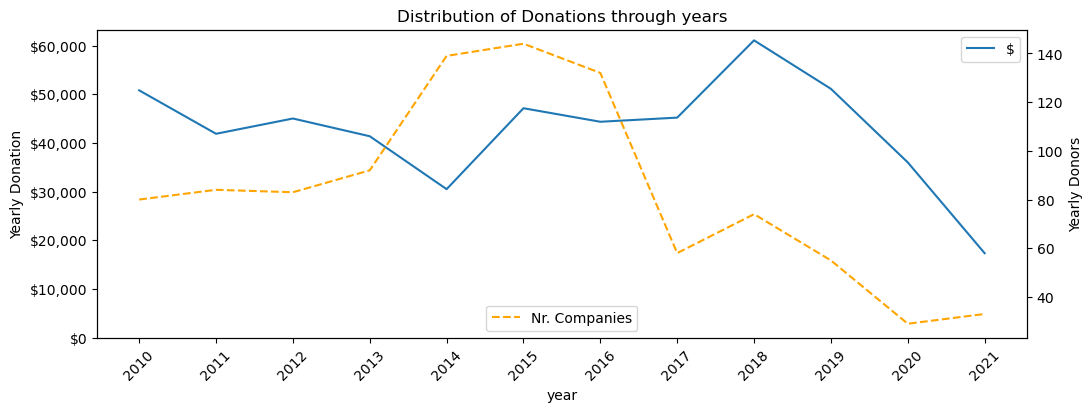

In [112]:
import matplotlib.ticker as mtick
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

fig, ax = plt.subplots(1,1, figsize = (12,4))
ax2 = ax.twinx()
sns.lineplot(ax = ax, data = df, x = 'year', y = 'dollar_equivalent_amount', estimator = sum, ci = None, label = '$')
sns.lineplot(ax = ax2, data = unq_pr_yr, x = 'year', y = 'company', estimator = sum, ci = None, dashes = True, label = 'Nr. Companies')

ax2.lines[0].set_linestyle("--")
ax2.lines[0].set_color('orange')

ax.yaxis.set_major_formatter(tick)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylim(bottom=0)
ax.set_title('Distribution of Donations through years')
ax.set_ylabel('Yearly Donation')
ax2.set_ylabel('Yearly Donors')

plt.legend(loc = 'lower center')
plt.show()


We see that years where the raised funds where highest (2018, 2019), it wasn't through more donors, but actually less companies doing larger donations. Comparatively, a year like 2014 where the donating companies were the highest at around 140, saw one of the lowest funds raised. 

There is strong case to analyze what donors are more helpful than others.

In [147]:
df_grouped

,total_donations,mean,count
0,1,188.611568,236
1,2,518.951687,83
2,3,1688.372881,59
3,4,991.440000,25
4,5,3092.857143,14
5,6,3657.428571,7
6,7,5503.125000,8
7,8,6192.000000,5
8,9,55719.000000,1
9,10,19100.000000,3


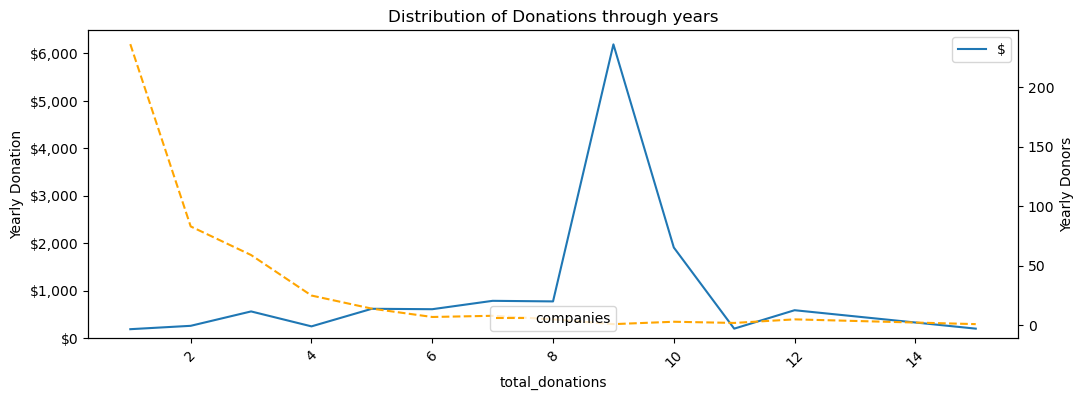

In [159]:
df_grouped = df.groupby('company')['dollar_equivalent_amount'].agg(['mean', 'count']).reset_index()
df_grouped = df_grouped.groupby('count')['mean'].agg(['mean', 'count']).rename_axis(index='total_donations').reset_index()


import matplotlib.ticker as mtick
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

fig, ax = plt.subplots(1,1, figsize = (12,4))
ax2 = ax.twinx()
sns.lineplot(ax = ax, data = df_grouped, x = 'total_donations', y = 'mean', estimator = sum, ci = None, label = '$')
sns.lineplot(ax = ax2, data = df_grouped, x = 'total_donations', y = 'count', estimator = sum, ci = None, label = 'companies')


ax2.lines[0].set_linestyle("--")
ax2.lines[0].set_color('orange')

ax.yaxis.set_major_formatter(tick)
ax.tick_params(axis='x', labelrotation = 45)
ax.set_ylim(bottom=0)
ax.set_title('Distribution of Donations through years')
ax.set_ylabel('Yearly Donation')
ax2.set_ylabel('Yearly Donors')

plt.legend(loc = 'lower center')
plt.show()


In [168]:
df_grouped['rel_freq'] = df_grouped['count']*100 /df_grouped['count'].sum()
df_grouped # .head(5)

,total_donations,mean,count,rel_freq
0,1,188.611568,236,52.561247
1,2,259.475843,83,18.485523
2,3,562.790960,59,13.140312
3,4,247.860000,25,5.567929
4,5,618.571429,14,3.118040
5,6,609.571429,7,1.559020
6,7,786.160714,8,1.781737
7,8,774.000000,5,1.113586
8,9,6191.000000,1,0.222717
9,10,1910.000000,3,0.668151


Companies that have donated in multiple years tend to offer larger average donations. Long-term supporters tend to provide more money. 

Is this the result of improving the aid overtime?

In [164]:
df.loc[:, 'donation_round'] = df.sort_values('added_modified').groupby('company')['company'].cumcount() + 1

c:\Users\carlo\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [180]:
freq_comps = df.loc[df.donation_round == 5 , 'company'].drop_duplicates().values

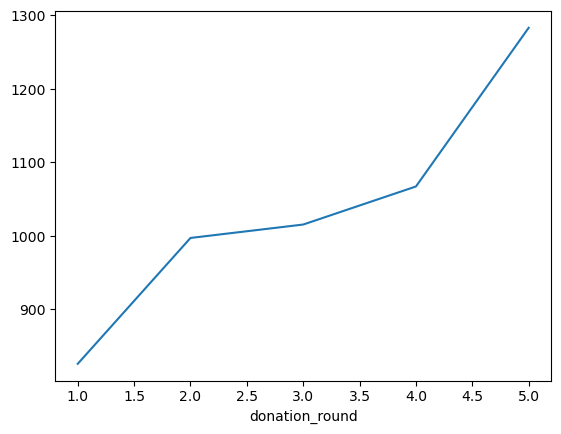

donation_round
1     825.897436
2     997.083333
3    1015.342105
4    1067.131579
5    1283.030303
Name: dollar_equivalent_amount, dtype: float64

In [196]:
df_freq.groupby('donation_round')['dollar_equivalent_amount'].mean().plot()
plt.show()

# for multi-donation companies, on average, the donation increases with each new contribution

df_freq.groupby('donation_round')['dollar_equivalent_amount'].mean()

In [167]:
# potentially expand analysis by studying interval between donations. 
# are companies donating with a systematic frequency e.g. every 2 years, 3? etc


46

In [233]:
df_pareto =df[df.dollar_equivalent_amount > 0].copy()

In [239]:
df_pareto = df_pareto.sort_values(['year', 'dollar_equivalent_amount'], ascending=False).reset_index()

In [242]:
import numpy as np

In [327]:
def pareto_per_year(df, years = ['2010', '2017', '2019'], q=5, verbose = True):
    top_donors_dcs = []
    for y in years:

        df_pareto =df.loc [(df.dollar_equivalent_amount > 0) & (df.year ==y)].copy().reset_index()
        df_pareto['quintile']= 5-pd.qcut(df_pareto.dollar_equivalent_amount, q = q, duplicates='drop', labels = False )

        df_p_g = df_pareto.groupby('quintile')['dollar_equivalent_amount'].agg(['sum', 'count']).reset_index()
        df_p_g['rel_sum']=df_p_g['sum'].div(df_p_g['sum'].sum() )*100
        df_p_g['rel_size']=df_p_g['count'].div(df_p_g['count'].sum() )*100

        r = df_p_g.nsmallest(1, 'quintile').to_dict('records')[0]    
        top_donors = df_pareto.loc[ df_pareto.quintile == df_pareto.quintile.min(), 'company' ].drop_duplicates().to_list()

        if verbose:
            print( f'''{y}: {r['count']} companies ({np.around(r['rel_size'],2)} of total) donated {np.around(r['rel_sum'],2)} of all the funds raised.''' ) 
        
        top_donors_dcs.append( {y : top_donors} )

    return top_donors_dcs

In [328]:
top_donors = pareto_per_year(df, years = df.year.drop_duplicates().to_list())

In [329]:
top_donors

[{'2010': ['VIA',
   'FONDATION BBB',
   'SUNDAY NIGHT CURLING',
   'WESTJET',
   'EPICOR',
   'CORBEC']},
 {'2011': ['VIA',
   'DELTA',
   'FONDATION BBB',
   'EPICOR',
   'ERNEST',
   'CORBEC',
   'CP']},
 {'2012': ['P A SUPER MARCHE',
   'FONDATION BBB',
   'FRIENDS OF TROUSER LAKE',
   'SUNDAY NIGHT CURLING',
   'VIA',
   'KUPER ACADEMY',
   'CORBEC',
   'DIRECTED ELECTRONICS',
   'ENERGIE CARDIO',
   'MARVIN A DRIMER FOUNDATION',
   'CP']},
 {'2013': ['VIA',
   'FONDATION BBB',
   'FRIENDS OF TROUSER LAKE',
   'SUNDAY CURLING GANG',
   'P A SUPER MARCHE',
   'CP',
   'MARVIN A DRIMER FOUNDATION',
   'OLA',
   'MACS',
   'DIRECTED ELECTRONICS',
   'NAKISA']},
 {'2014': ['FRIENDS OF TROUSER LAKE',
   'FONDATION BBB',
   'SUNDAY CURLING GANG',
   'CP',
   'BMA',
   'SERVICES INTEGRES LEMAY ET ASSOCIES INC',
   'VILLE DE SOREL TRACY',
   'FIERA CAPITAL',
   'GL V']},
 {'2015': ['SUNDAY CURLING GANG',
   'ASSOCIATION DES ARBITRAGES INST DE MONTREAL',
   'FONDATION BBB',
   'LORNE STEIN

In [ ]:
df_top_peryear = df.set_index('company').groupby('year')['dollar_amount_float'].nlargest(5).reset_index()
fig, ax = plt.subplots(figsize=(14,6))

sns.boxplot(ax = ax, data = df, x= 'year', y = 'dollar_amount_float')
plt.suptitle('Distribution of corporate donations per year')
plt.show()

In [ ]:
month_periods = df_concat.added_modified_clean.dt.to_period('M').astype(str)
month_counts = month_periods.value_counts().rename_axis('year_month').reset_index()
month_counts = month_counts.sort_values('year_month')

month_counts['year'] = month_counts.year_month.str[:4]
month_counts['month'] = month_counts.year_month.str[5:]

pivot_month_counts = month_counts.pivot( "month", "year","added_modified_clean").fillna(0).astype(int)

pivot_month_counts = pivot_month_counts.drop(columns = ['NaT'])

sns.lineplot(data = pivot_month_counts)
plt.suptitle('No. of corporate donations per month ')
plt.title('(2010 to 2022)')
plt.show()

In [ ]:
pivot_month_counts.sum().plot(kind = 'bar', rot = 50)
plt.suptitle('Total corporate donations per year')
plt.show()